In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', None)        # Show all rows
pd.set_option('display.max_columns', None)     # Show all columns
pd.set_option('display.width', None)           # Disable line wrapping
pd.set_option('display.max_colwidth', None)    # Show full column content (especially for strings)

def load_and_sort_csv(path):
    df = pd.read_csv(
        path,
        parse_dates=['Date'],
        index_col='Date',
        date_format='%d/%m/%y'
    )

    df.index = pd.to_datetime(df.index)
    return df
path = '../data/final/dataset.csv'

In [3]:
df = load_and_sort_csv(path)

df['Oil_Crude_Price'] = df['Oil_Crude_Price'].clip(lower=0)

X = df.drop(columns=['btc_close'], axis=1)
y = df['btc_close']

## Handling Missing data

In [41]:
# Check and print columns that contain zero values or NaN values
zero_columns = []
nan_columns = []

for column in df.columns:
    # Check for zeros
    zero_count = (df[column] == 0).sum()
    if zero_count > 0:
        print(f"Column '{column}' has {zero_count} zero values")
        zero_columns.append(column)
    
    # Check for NaNs
    nan_count = df[column].isna().sum()
    if nan_count > 0:
        print(f"Column '{column}' has {nan_count} NaN values")
        nan_columns.append(column)

if not zero_columns and not nan_columns:
    print("No columns contain zero values or NaN values")

print("\nSummary:")
print(f"Total columns with zeros: {len(zero_columns)}")
print(f"Total columns with NaNs: {len(nan_columns)}")

No columns contain zero values or NaN values

Summary:
Total columns with zeros: 0
Total columns with NaNs: 0


In [4]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# --- The Main Imputation Function (Unchanged from before) ---

def robust_time_series_imputation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Performs a robust, multi-step imputation on a time series DataFrame
    with a corrected, more logical order of operations.

    The strategy is ordered from most to least sophisticated:
    1. Use a multivariate imputer (IterativeImputer) as the primary method to
       fill gaps by leveraging inter-variable correlations.
    2. Apply time-based interpolation to fill any gaps the model might have missed.
    3. Use a simple forward/backward fill as a final, robust cleanup step to
       guarantee no NaNs remain, especially at the edges.

    Args:
        df (pd.DataFrame): The input DataFrame with a DatetimeIndex and
                           columns containing missing values (NaNs).

    Returns:
        pd.DataFrame: A fully imputed DataFrame with the same shape as the input.
    """
    print("Starting robust time series imputation with corrected logic...")

    if df.isnull().sum().sum() == 0:
        print("No missing values detected. Returning original dataframe.")
        return df

    original_index = df.index
    original_columns = df.columns
    df_imputed = df.copy()

    # --- Step 1 (Primary): Multivariate Imputation with IterativeImputer ---
    # This is now the FIRST step. It's the most sophisticated model, using relationships
    # between columns to make intelligent imputations for all types of gaps.
    print("\nStep 1: Performing multivariate imputation with IterativeImputer...")
    nans_before_iterative = df_imputed.isnull().sum().sum()

    imputer = IterativeImputer(
        estimator=BayesianRidge(),
        max_iter=10,
        random_state=42,
        initial_strategy='mean',
        imputation_order='ascending'
    )

    imputed_data = imputer.fit_transform(df_imputed)
    df_imputed = pd.DataFrame(imputed_data, index=original_index, columns=original_columns)
    print(f"   > Filled {nans_before_iterative - df_imputed.isnull().sum().sum()} NaNs using variable correlations.")

    if df_imputed.isnull().sum().sum() == 0:
        print("Imputation complete after Step 1.")
        return df_imputed

    # --- Step 2 (Secondary): Univariate Time Series Interpolation ---
    # This handles any gaps that IterativeImputer may have missed, for example,
    # if an entire row was NaN, giving the imputer no features to work from.
    # Polynomial interpolation can capture non-linear trends.
    print("\nStep 2: Applying polynomial interpolation for any remaining gaps...")
    nans_before_interp = df_imputed.isnull().sum().sum()
    df_imputed = df_imputed.interpolate(method='polynomial', order=2, limit_direction='both')
    print(f"   > Filled {nans_before_interp - df_imputed.isnull().sum().sum()} NaNs via interpolation.")

    # --- Step 3 (Final Cleanup): Forward and Backward Fill ---
    # This is now the LAST resort. Its aggressive fill is safe here, as it only
    # cleans up any stubborn NaNs left at the absolute edges of the dataset
    # by the more advanced methods.
    if df_imputed.isnull().sum().sum() > 0:
        print("\nStep 3: Performing final ffill/bfill cleanup for edges...")
        nans_before_fallback = df_imputed.isnull().sum().sum()
        df_imputed = df_imputed.ffill().bfill()
        print(f"   > Filled {nans_before_fallback} remaining NaNs.")

    print("\nImputation complete. Final check for missing values:")
    print(f"Total NaNs in final DataFrame: {df_imputed.isnull().sum().sum()}")
    return df_imputed


# --- Main Application Script with New Pre-processing Steps ---

# Load the dataset
df = load_and_sort_csv(path)

print("\nInitial state of DataFrame with missing values (showing sums):")
print("Note: Zeros are not yet counted as missing.")
print(df.isnull().sum())
print("-" * 50)


# --- THE IMPROVED WORKFLOW ---

# Step 1 (NEW): Convert meaningful zeros to NaNs
# This tells the imputation functions to treat them as missing.
print("\nWORKFLOW STEP 1: Converting meaningful zeros to NaN...")
for col in df.columns:
    df[col] = df[col].replace(0, np.nan)
print("NaN counts after converting zeros:")
print(df.isnull().sum())
print("-" * 50)


# Step 2 (NEW): Handle systematic weekend gaps with forward fill
# This is the most logical way to fill data for markets closed on weekends.
print("\nWORKFLOW STEP 2: Forward-filling weekend gaps in cross-market data...")
cbbi_columns = [
    "PiCycle_cbbi",
    "RUPL_cbbi",
    "RHODL_cbbi",
    "Puell_cbbi",
    "2YMA_cbbi",
    "Trolololo_cbbi",
    "MVRV_cbbi",
    "ReserveRisk_cbbi",
    "Woobull_cbbi",
    "Confidence_cbbi"
]

cols_other_than_cbbi = [col for col in df.columns if col not in cbbi_columns + ['btc_close']]

df[cols_other_than_cbbi] = df[cols_other_than_cbbi].interpolate(method='time').ffill().bfill()
print("NaN counts after forward-filling weekends:")
print(df.isnull().sum())
print("-" * 50)

# Step 3 (EXISTING): Run the robust imputation function for any remaining NaNs
# This will now handle the converted sentiment zeros and the random gaps in 'close_price'.
print("\nWORKFLOW STEP 3: Running robust imputation for all remaining complex gaps...")
df_imputed_final = robust_time_series_imputation(df[cbbi_columns])

# Update the CBBI columns in the main DataFrame with the imputed values
df[cbbi_columns] = df_imputed_final

print(f"\nTotal NaNs in final DataFrame: {df.isnull().sum().sum()}")
print("-" * 50)


Initial state of DataFrame with missing values (showing sums):
Note: Zeros are not yet counted as missing.
btc_sma_5                                        0
btc_ema_5                                        0
btc_sma_14                                       0
btc_ema_14                                       0
btc_sma_21                                       0
btc_ema_21                                       0
btc_sma_50                                       0
btc_ema_50                                       0
btc_sma_14_50_diff                               0
btc_ema_14_50_diff                               0
btc_sma_14_50_ratio                              0
btc_sma_14_slope                                 0
btc_ema_14_slope                                 0
btc_sma_21_slope                                 0
btc_ema_21_slope                                 0
btc_sma_50_slope                                 0
btc_ema_50_slope                                 0
btc_close_ema_21_dist    

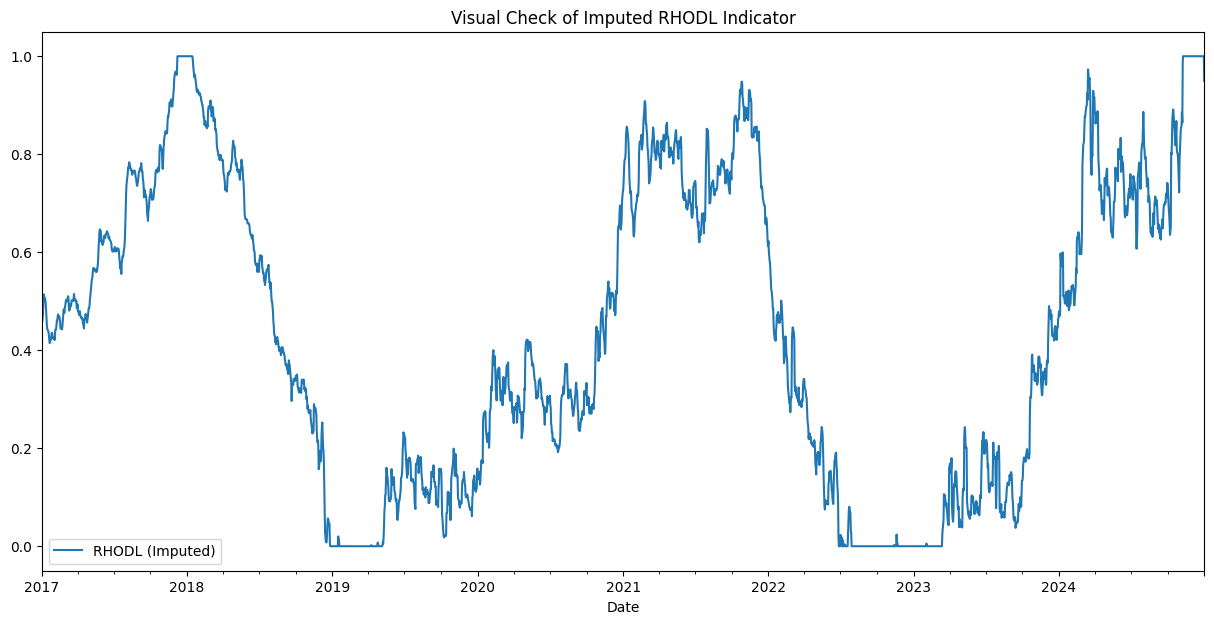

In [ ]:
import matplotlib.pyplot as plt

# After running the full imputation...
fig, ax = plt.subplots(figsize=(15, 7))
df['RHODL_cbbi'].plot(ax=ax, label='RHODL')
ax.set_title('Visual Check of Imputed RHODL Indicator')
ax.legend()
plt.show()

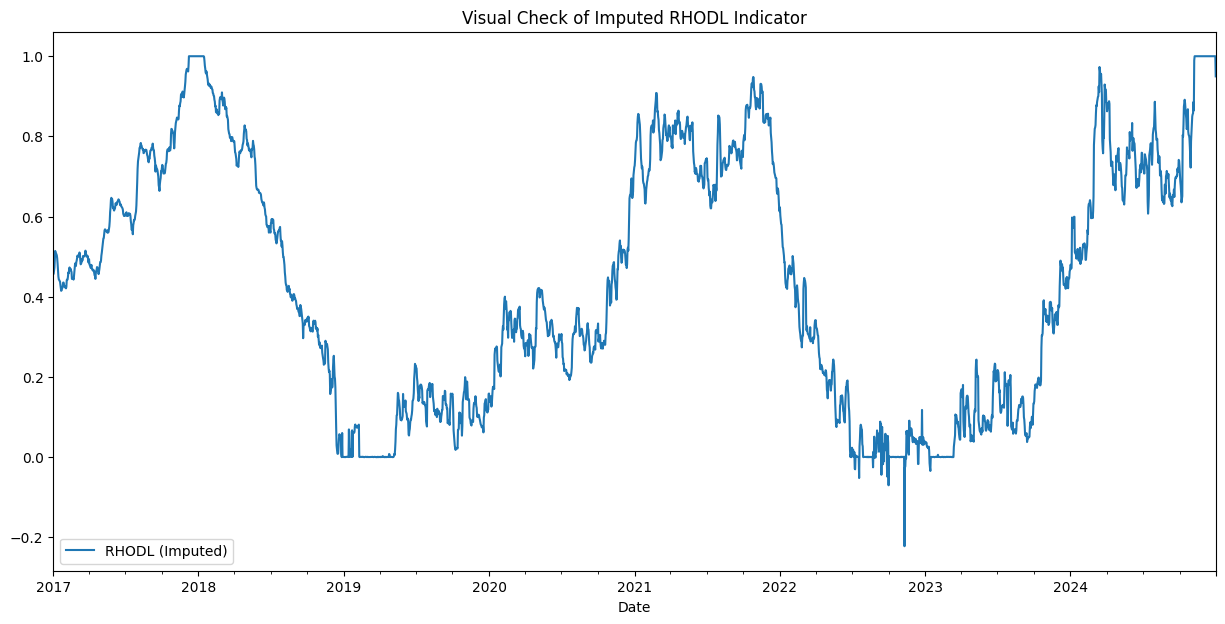

In [4]:
import matplotlib.pyplot as plt

# After running the full imputation...
fig, ax = plt.subplots(figsize=(15, 7))
df['RHODL_cbbi'].plot(ax=ax, label='RHODL (Imputed)')
ax.set_title('Visual Check of Imputed RHODL Indicator')
ax.legend()
plt.show()

In [6]:
df = df.reset_index()

df.head()

,Date,btc_sma_5,btc_ema_5,btc_sma_14,btc_ema_14,btc_sma_21,btc_ema_21,btc_sma_50,btc_ema_50,btc_sma_14_50_diff,btc_ema_14_50_diff,btc_sma_14_50_ratio,btc_sma_14_slope,btc_ema_14_slope,btc_sma_21_slope,btc_ema_21_slope,btc_sma_50_slope,btc_ema_50_slope,btc_close_ema_21_dist,btc_close_ema_21_dist_norm,btc_rsi_14,btc_macd,btc_macd_signal,btc_macd_diff,btc_bb_high,btc_bb_low,btc_bb_mid,btc_bb_width,btc_atr_14,btc_volatility_index,btc_trading_volume,active_addresses_blockchain,hash_rate_blockchain,miner_revenue_blockchain,difficulty_blockchain,estimated_transaction_volume_usd_blockchain,PiCycle_cbbi,RUPL_cbbi,RHODL_cbbi,Puell_cbbi,2YMA_cbbi,Trolololo_cbbi,MVRV_cbbi,ReserveRisk_cbbi,Woobull_cbbi,Confidence_cbbi,Fear Greed,positive_sentiment,negative_sentiment,bullish_sentiment,bearish_sentiment,risk_uncertainty_sentiment,problem_malicious_sentiment,active_trading_sentiment,long_term_investment_sentiment,market_narrative_sentiment,core_technology_sentiment,development_ecosystem_sentiment,news_events_sentiment,regulations_sentiment,community_social_sentiment,price_sentiment,volume_sentiment,marketcap_sentiment,Gold_Price,Gold_Share,Gold_Volatility,Oil_Crude_Price,Oil_Brent_Price,Oil_Volatility,DJI,GSPC,IXIC,NYFANG,CBOE_Volatility,EM_ETF,DXY,EURUSD,btc_close
0,2017-01-01,974.544800,968.763975,908.780853,917.957205,867.114761,888.108727,798.158420,816.719767,110.622433,100.983404,1.138597,67.634927,60.643935,48.409854,53.226265,26.052079,35.013269,110.216286,0.110401,85.061012,53.447164,46.015756,10.465832,1027.196256,715.736044,871.466150,35.739795,24.732607,44.381042,147775008.0,355325,2463610.662,1970085.325,3.176880e+11,166788994.4,0.5909,0.8431,0.4559,0.4440,0.4951,0.0033,0.6056,0.2475,0.4111,0.4552,70.0,222.4,114.428571,113.0,41.0,48.4,33.571429,79.000,197.625,13.0,60.750,95.363636,49.625,45.6,20.2,867.0,38.0,26.0,1156.400024,110.290001,15.68,53.770000,56.139999,30.010000,19819.77930,2249.260010,5432.089844,1423.189941,13.37,29.488140,102.680000,1.057530,998.325012
1,2017-01-02,983.710596,986.425984,925.140568,931.796244,878.622524,900.257933,804.552800,824.760168,120.587768,106.815914,1.149882,70.106070,58.668608,50.022903,52.553785,27.124999,35.437414,121.492067,0.118906,86.779600,56.965028,48.769272,11.014066,1046.419181,720.632516,883.525848,36.873473,25.443705,34.687988,222184992.0,529709,2526780.166,2138666.021,3.176880e+11,279981138.0,0.5924,0.8511,0.4570,0.4576,0.5011,0.0111,0.6086,0.2500,0.4173,0.4607,70.0,281.2,173.142857,124.0,59.0,60.2,54.428571,108.500,258.750,20.0,94.625,143.636364,65.625,62.8,32.8,1203.0,58.0,51.0,1150.000000,109.610001,16.23,53.720001,56.130001,30.830000,19762.59961,2238.830078,5383.120117,1405.060059,14.04,29.279070,102.389999,1.052698,1021.750000
2,2017-01-03,997.779187,1005.563978,942.495139,946.735407,891.159854,913.310845,811.329180,833.351533,131.165959,113.193067,1.161668,73.502856,60.225187,52.908471,54.170982,28.896898,36.806259,130.529120,0.125047,88.162557,60.834177,51.705628,11.745422,1066.653823,726.633768,896.643796,37.921419,25.232011,22.479980,185168000.0,515024,2589949.671,2245225.092,3.176880e+11,341754284.9,0.5941,0.8555,0.4655,0.4740,0.5132,0.0269,0.6195,0.2602,0.4302,0.4710,70.0,268.4,175.428571,87.0,65.0,60.6,62.571429,90.375,251.375,16.2,99.000,155.454545,74.250,85.4,28.4,955.0,32.0,47.0,1160.400024,110.470001,16.26,52.330002,55.470001,32.880001,19881.75977,2257.830078,5429.080078,1416.569946,12.85,29.630316,103.209999,1.046003,1043.839966
3,2017-01-04,1036.477588,1055.285979,965.384351,974.468017,908.933614,935.258039,820.191399,845.954609,145.192953,128.348041,1.177023,83.796997,77.994096,61.708708,66.836530,32.845038,42.950798,219.471941,0.190063,92.438640,72.018222,56.253993,18.193459,1110.400030,720.551758,915.475894,42.584220,31.685444,115.020020,344945984.0,545609,2432025.910,2332472.035,3.176880e+11,433678086.9,0.5959,0.8584,0.4725,0.4826,0.5167,0.0315,0.6448,0.2670,0.4334,0.4781,70.0,357.8,237.000000,201.0,86.0,79.2,74.142857,159.875,357.000,31.2,130.000,183.909091,1

In [7]:
df.to_parquet("dataset.parquet")